# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pickle
import torch

from agent import Agent, BATCH_SIZE, BUFFER_SIZE

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
# env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")
env = UnityEnvironment(file_name="Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Training the agent

Now the agent will be trained through experience in the environment. For this part, there are multiple choices of memory buffers to use. The `UniformReplayBuffer` selects memories randomly uniform. Both ProportionalReplayBuffer and RankBasedReplayBuffer implement [Prioritized Experience Replay](https://arxiv.org/pdf/1511.05952.pdf).

In the `ProportionalReplayBuffer`, the experiences are sampled with a proportional priority of `p(i) = |td_error(i)| + e`, where `e` is a constant provided on the constructor of the class. After the memory is full, the oldest experience is deleted before inserting a new experience.

In the `RankBasedReplayBuffer`, the experiences are sampled with a proportional priority of `p(i) = 1/rank(i)`, where the rank is defined by the position of the experience on a descending sorted array. 

In [7]:
from models.model_64 import QNetwork
from replay_buffer import ProportionalReplayBuffer, RankBasedReplayBuffer, UniformReplayBuffer

seed = 0

model = QNetwork

memory = UniformReplayBuffer(action_size, BATCH_SIZE, BUFFER_SIZE, seed)
# memory = ProportionalReplayBuffer(action_size, BATCH_SIZE, BUFFER_SIZE, e=0.2, alpha=0.5, beta0=0.1, beta_inc=0.02, seed=seed)
# memory = RankBasedReplayBuffer(action_size, BATCH_SIZE, BUFFER_SIZE, buffer_type='array', alpha=0.5, beta0=0.1, beta_inc=0.02, seed=seed)
agent = Agent(state_size, action_size, model, memory, seed=0)

In [8]:
checkpoints_folder = 'checkpoints'

def save_model(model, suffix=''):
    file_name = f'checkpoint_{model_name}'
    if suffix:
        file_name += f'_{suffix}'
    file_name = f'{file_name}.pkl' # add file extension
    file_path = os.path.join(checkpoints_folder, file_name)
    torch.save(model.state_dict(), file_path)
def save_scores(scores):
    file_name = f'score_{model_name}.pkl'
    file_path = os.path.join(checkpoints_folder, file_name)
    pickle.dump(scores, open(file_path, 'wb'))
def step_env(action):
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations[0]
    reward = env_info.rewards[0] 
    done = env_info.local_done[0]  
    return (next_state, reward, done)

In [9]:
model_name = 'dqn_64'

def dqn(n_episodes=2000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, save_scores_every=50):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    # the target score after each episode.
    target_score = 13
    
    # list containing scores from each episode.
    scores = []
    
    # the number of consecultive times that the target score has been reached.
    reached_score_times = 0
    
    # last 100 scores
    scores_window = deque(maxlen=100)
    
    # initialize epsilon
    eps = eps_start
    
    # if the model achieved the goal for the first time or not.
    reached_goal = False
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        done = False
        while not done:
            action = agent.act(state, eps)
            next_state, reward, done = step_env(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        
        eps = max(eps_end, eps_decay**2*eps) # decrease epsilon

        print('\rEpisode {}\tScore: {:.2f}\tAverage Score: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, score, np.mean(scores_window), eps))
            
        if i_episode % save_scores_every == 0:
            save_scores(scores)
        
        if np.mean(scores_window) > 13 and not reached_goal:
            reached_goal = True
            save_model(agent.qnetwork_local, 'goal')
            print(f'Achieved goal on the episode {i_episode}')
    
    save_model(agent.qnetwork_local)
    save_scores(scores)
    
    return scores

scores = dqn()

Episode 1	Score: 0.00	Average Score: 0.00	Epsilon: 0.99
Episode 2	Score: 1.00	Average Score: 0.50	Epsilon: 0.98
Episode 3	Score: 0.00	Average Score: 0.33	Epsilon: 0.97
Episode 4	Score: 0.00	Average Score: 0.25	Epsilon: 0.96
Episode 5	Score: 1.00	Average Score: 0.40	Epsilon: 0.95
Episode 6	Score: -3.00	Average Score: -0.17	Epsilon: 0.94
Episode 7	Score: 0.00	Average Score: -0.14	Epsilon: 0.93
Episode 8	Score: -1.00	Average Score: -0.25	Epsilon: 0.92
Episode 9	Score: 0.00	Average Score: -0.22	Epsilon: 0.91
Episode 10	Score: 1.00	Average Score: -0.10	Epsilon: 0.90
Episode 11	Score: 0.00	Average Score: -0.09	Epsilon: 0.90
Episode 12	Score: 1.00	Average Score: 0.00	Epsilon: 0.89
Episode 13	Score: 0.00	Average Score: 0.00	Epsilon: 0.88
Episode 14	Score: -1.00	Average Score: -0.07	Epsilon: 0.87
Episode 15	Score: 1.00	Average Score: 0.00	Epsilon: 0.86
Episode 16	Score: 1.00	Average Score: 0.06	Epsilon: 0.85
Episode 17	Score: 2.00	Average Score: 0.18	Epsilon: 0.84
Episode 18	Score: 0.00	Average

Episode 144	Score: 11.00	Average Score: 4.22	Epsilon: 0.24
Episode 145	Score: 5.00	Average Score: 4.24	Epsilon: 0.23
Episode 146	Score: 8.00	Average Score: 4.27	Epsilon: 0.23
Episode 147	Score: 11.00	Average Score: 4.36	Epsilon: 0.23
Episode 148	Score: 10.00	Average Score: 4.43	Epsilon: 0.23
Episode 149	Score: 8.00	Average Score: 4.45	Epsilon: 0.22
Episode 150	Score: 8.00	Average Score: 4.50	Epsilon: 0.22
Episode 151	Score: 4.00	Average Score: 4.51	Epsilon: 0.22
Episode 152	Score: 8.00	Average Score: 4.56	Epsilon: 0.22
Episode 153	Score: 2.00	Average Score: 4.58	Epsilon: 0.22
Episode 154	Score: 6.00	Average Score: 4.64	Epsilon: 0.21
Episode 155	Score: 6.00	Average Score: 4.71	Epsilon: 0.21
Episode 156	Score: 8.00	Average Score: 4.79	Epsilon: 0.21
Episode 157	Score: 8.00	Average Score: 4.82	Epsilon: 0.21
Episode 158	Score: 7.00	Average Score: 4.82	Epsilon: 0.21
Episode 159	Score: 3.00	Average Score: 4.84	Epsilon: 0.20
Episode 160	Score: 6.00	Average Score: 4.87	Epsilon: 0.20
Episode 161

Episode 284	Score: 13.00	Average Score: 10.60	Epsilon: 0.06
Episode 285	Score: 11.00	Average Score: 10.68	Epsilon: 0.06
Episode 286	Score: 15.00	Average Score: 10.75	Epsilon: 0.06
Episode 287	Score: 4.00	Average Score: 10.72	Epsilon: 0.06
Episode 288	Score: 12.00	Average Score: 10.77	Epsilon: 0.06
Episode 289	Score: 14.00	Average Score: 10.80	Epsilon: 0.06
Episode 290	Score: 10.00	Average Score: 10.77	Epsilon: 0.05
Episode 291	Score: 17.00	Average Score: 10.89	Epsilon: 0.05
Episode 292	Score: 19.00	Average Score: 10.91	Epsilon: 0.05
Episode 293	Score: 15.00	Average Score: 10.97	Epsilon: 0.05
Episode 294	Score: 10.00	Average Score: 10.99	Epsilon: 0.05
Episode 295	Score: 10.00	Average Score: 10.96	Epsilon: 0.05
Episode 296	Score: 8.00	Average Score: 10.92	Epsilon: 0.05
Episode 297	Score: 16.00	Average Score: 10.96	Epsilon: 0.05
Episode 298	Score: 14.00	Average Score: 11.01	Epsilon: 0.05
Episode 299	Score: 21.00	Average Score: 11.13	Epsilon: 0.05
Episode 300	Score: 13.00	Average Score: 11

Episode 421	Score: 11.00	Average Score: 14.66	Epsilon: 0.01
Episode 422	Score: 16.00	Average Score: 14.68	Epsilon: 0.01
Episode 423	Score: 13.00	Average Score: 14.67	Epsilon: 0.01
Episode 424	Score: 18.00	Average Score: 14.76	Epsilon: 0.01
Episode 425	Score: 18.00	Average Score: 14.79	Epsilon: 0.01
Episode 426	Score: 19.00	Average Score: 14.82	Epsilon: 0.01
Episode 427	Score: 23.00	Average Score: 14.90	Epsilon: 0.01
Episode 428	Score: 18.00	Average Score: 14.93	Epsilon: 0.01
Episode 429	Score: 17.00	Average Score: 14.98	Epsilon: 0.01
Episode 430	Score: 17.00	Average Score: 15.00	Epsilon: 0.01
Episode 431	Score: 12.00	Average Score: 14.96	Epsilon: 0.01
Episode 432	Score: 19.00	Average Score: 15.04	Epsilon: 0.01
Episode 433	Score: 18.00	Average Score: 15.01	Epsilon: 0.01
Episode 434	Score: 5.00	Average Score: 14.95	Epsilon: 0.01
Episode 435	Score: 16.00	Average Score: 14.95	Epsilon: 0.01
Episode 436	Score: 18.00	Average Score: 14.97	Epsilon: 0.01
Episode 437	Score: 18.00	Average Score: 1

Episode 558	Score: 15.00	Average Score: 14.28	Epsilon: 0.01
Episode 559	Score: 24.00	Average Score: 14.42	Epsilon: 0.01
Episode 560	Score: 21.00	Average Score: 14.46	Epsilon: 0.01
Episode 561	Score: 9.00	Average Score: 14.45	Epsilon: 0.01
Episode 562	Score: 14.00	Average Score: 14.49	Epsilon: 0.01
Episode 563	Score: 21.00	Average Score: 14.55	Epsilon: 0.01
Episode 564	Score: 6.00	Average Score: 14.52	Epsilon: 0.01
Episode 565	Score: 14.00	Average Score: 14.52	Epsilon: 0.01
Episode 566	Score: 15.00	Average Score: 14.49	Epsilon: 0.01
Episode 567	Score: 15.00	Average Score: 14.41	Epsilon: 0.01
Episode 568	Score: 18.00	Average Score: 14.47	Epsilon: 0.01
Episode 569	Score: 14.00	Average Score: 14.42	Epsilon: 0.01
Episode 570	Score: 17.00	Average Score: 14.40	Epsilon: 0.01
Episode 571	Score: 20.00	Average Score: 14.47	Epsilon: 0.01
Episode 572	Score: 20.00	Average Score: 14.50	Epsilon: 0.01
Episode 573	Score: 23.00	Average Score: 14.73	Epsilon: 0.01
Episode 574	Score: 13.00	Average Score: 14

Episode 695	Score: 15.00	Average Score: 15.46	Epsilon: 0.01
Episode 696	Score: 21.00	Average Score: 15.49	Epsilon: 0.01
Episode 697	Score: 20.00	Average Score: 15.52	Epsilon: 0.01
Episode 698	Score: 11.00	Average Score: 15.49	Epsilon: 0.01
Episode 699	Score: 16.00	Average Score: 15.43	Epsilon: 0.01
Episode 700	Score: 15.00	Average Score: 15.46	Epsilon: 0.01
Episode 701	Score: 16.00	Average Score: 15.45	Epsilon: 0.01
Episode 702	Score: 19.00	Average Score: 15.44	Epsilon: 0.01
Episode 703	Score: 22.00	Average Score: 15.48	Epsilon: 0.01
Episode 704	Score: 18.00	Average Score: 15.52	Epsilon: 0.01
Episode 705	Score: 14.00	Average Score: 15.57	Epsilon: 0.01
Episode 706	Score: 21.00	Average Score: 15.70	Epsilon: 0.01
Episode 707	Score: 22.00	Average Score: 15.85	Epsilon: 0.01
Episode 708	Score: 18.00	Average Score: 15.85	Epsilon: 0.01
Episode 709	Score: 16.00	Average Score: 15.86	Epsilon: 0.01
Episode 710	Score: 14.00	Average Score: 15.86	Epsilon: 0.01
Episode 711	Score: 18.00	Average Score: 

Episode 832	Score: 17.00	Average Score: 15.82	Epsilon: 0.01
Episode 833	Score: 19.00	Average Score: 15.89	Epsilon: 0.01
Episode 834	Score: 22.00	Average Score: 15.92	Epsilon: 0.01
Episode 835	Score: 14.00	Average Score: 15.90	Epsilon: 0.01
Episode 836	Score: 12.00	Average Score: 15.87	Epsilon: 0.01
Episode 837	Score: 17.00	Average Score: 15.85	Epsilon: 0.01
Episode 838	Score: 18.00	Average Score: 15.87	Epsilon: 0.01
Episode 839	Score: 18.00	Average Score: 15.91	Epsilon: 0.01
Episode 840	Score: 17.00	Average Score: 15.92	Epsilon: 0.01
Episode 841	Score: 13.00	Average Score: 15.89	Epsilon: 0.01
Episode 842	Score: 12.00	Average Score: 15.75	Epsilon: 0.01
Episode 843	Score: 13.00	Average Score: 15.68	Epsilon: 0.01
Episode 844	Score: 16.00	Average Score: 15.70	Epsilon: 0.01
Episode 845	Score: 11.00	Average Score: 15.65	Epsilon: 0.01
Episode 846	Score: 19.00	Average Score: 15.63	Epsilon: 0.01
Episode 847	Score: 16.00	Average Score: 15.59	Epsilon: 0.01
Episode 848	Score: 21.00	Average Score: 

Episode 969	Score: 15.00	Average Score: 16.02	Epsilon: 0.01
Episode 970	Score: 14.00	Average Score: 15.97	Epsilon: 0.01
Episode 971	Score: 13.00	Average Score: 15.93	Epsilon: 0.01
Episode 972	Score: 14.00	Average Score: 15.95	Epsilon: 0.01
Episode 973	Score: 11.00	Average Score: 15.87	Epsilon: 0.01
Episode 974	Score: 15.00	Average Score: 15.94	Epsilon: 0.01
Episode 975	Score: 18.00	Average Score: 16.06	Epsilon: 0.01
Episode 976	Score: 2.00	Average Score: 15.89	Epsilon: 0.01
Episode 977	Score: 17.00	Average Score: 15.86	Epsilon: 0.01
Episode 978	Score: 12.00	Average Score: 15.80	Epsilon: 0.01
Episode 979	Score: 12.00	Average Score: 15.70	Epsilon: 0.01
Episode 980	Score: 15.00	Average Score: 15.70	Epsilon: 0.01
Episode 981	Score: 14.00	Average Score: 15.70	Epsilon: 0.01
Episode 982	Score: 12.00	Average Score: 15.65	Epsilon: 0.01
Episode 983	Score: 17.00	Average Score: 15.63	Epsilon: 0.01
Episode 984	Score: 22.00	Average Score: 15.68	Epsilon: 0.01
Episode 985	Score: 17.00	Average Score: 1

Episode 1104	Score: 21.00	Average Score: 16.07	Epsilon: 0.01
Episode 1105	Score: 11.00	Average Score: 15.98	Epsilon: 0.01
Episode 1106	Score: 15.00	Average Score: 15.97	Epsilon: 0.01
Episode 1107	Score: 13.00	Average Score: 15.92	Epsilon: 0.01
Episode 1108	Score: 15.00	Average Score: 15.87	Epsilon: 0.01
Episode 1109	Score: 16.00	Average Score: 15.87	Epsilon: 0.01
Episode 1110	Score: 18.00	Average Score: 15.89	Epsilon: 0.01
Episode 1111	Score: 16.00	Average Score: 15.88	Epsilon: 0.01
Episode 1112	Score: 7.00	Average Score: 15.72	Epsilon: 0.01
Episode 1113	Score: 18.00	Average Score: 15.68	Epsilon: 0.01
Episode 1114	Score: 19.00	Average Score: 15.70	Epsilon: 0.01
Episode 1115	Score: 9.00	Average Score: 15.66	Epsilon: 0.01
Episode 1116	Score: 13.00	Average Score: 15.60	Epsilon: 0.01
Episode 1117	Score: 17.00	Average Score: 15.59	Epsilon: 0.01
Episode 1118	Score: 14.00	Average Score: 15.55	Epsilon: 0.01
Episode 1119	Score: 18.00	Average Score: 15.52	Epsilon: 0.01
Episode 1120	Score: 11.00	

Episode 1239	Score: 19.00	Average Score: 16.07	Epsilon: 0.01
Episode 1240	Score: 18.00	Average Score: 16.07	Epsilon: 0.01
Episode 1241	Score: 19.00	Average Score: 16.08	Epsilon: 0.01
Episode 1242	Score: 8.00	Average Score: 15.95	Epsilon: 0.01
Episode 1243	Score: 20.00	Average Score: 15.95	Epsilon: 0.01
Episode 1244	Score: 6.00	Average Score: 15.87	Epsilon: 0.01
Episode 1245	Score: 25.00	Average Score: 16.00	Epsilon: 0.01
Episode 1246	Score: 14.00	Average Score: 15.96	Epsilon: 0.01
Episode 1247	Score: 13.00	Average Score: 15.94	Epsilon: 0.01
Episode 1248	Score: 12.00	Average Score: 15.91	Epsilon: 0.01
Episode 1249	Score: 8.00	Average Score: 15.91	Epsilon: 0.01
Episode 1250	Score: 18.00	Average Score: 15.94	Epsilon: 0.01
Episode 1251	Score: 17.00	Average Score: 15.94	Epsilon: 0.01
Episode 1252	Score: 18.00	Average Score: 15.91	Epsilon: 0.01
Episode 1253	Score: 12.00	Average Score: 15.78	Epsilon: 0.01
Episode 1254	Score: 3.00	Average Score: 15.70	Epsilon: 0.01
Episode 1255	Score: 17.00	Av

Episode 1374	Score: 15.00	Average Score: 15.71	Epsilon: 0.01
Episode 1375	Score: 15.00	Average Score: 15.69	Epsilon: 0.01
Episode 1376	Score: 11.00	Average Score: 15.65	Epsilon: 0.01
Episode 1377	Score: 10.00	Average Score: 15.62	Epsilon: 0.01
Episode 1378	Score: 16.00	Average Score: 15.57	Epsilon: 0.01
Episode 1379	Score: 14.00	Average Score: 15.57	Epsilon: 0.01
Episode 1380	Score: 20.00	Average Score: 15.62	Epsilon: 0.01
Episode 1381	Score: 13.00	Average Score: 15.58	Epsilon: 0.01
Episode 1382	Score: 19.00	Average Score: 15.59	Epsilon: 0.01
Episode 1383	Score: 19.00	Average Score: 15.64	Epsilon: 0.01
Episode 1384	Score: 10.00	Average Score: 15.60	Epsilon: 0.01
Episode 1385	Score: 10.00	Average Score: 15.59	Epsilon: 0.01
Episode 1386	Score: 15.00	Average Score: 15.61	Epsilon: 0.01
Episode 1387	Score: 17.00	Average Score: 15.63	Epsilon: 0.01
Episode 1388	Score: 12.00	Average Score: 15.57	Epsilon: 0.01
Episode 1389	Score: 18.00	Average Score: 15.64	Epsilon: 0.01
Episode 1390	Score: 22.0

Episode 1509	Score: 10.00	Average Score: 16.35	Epsilon: 0.01
Episode 1510	Score: 15.00	Average Score: 16.33	Epsilon: 0.01
Episode 1511	Score: 16.00	Average Score: 16.30	Epsilon: 0.01
Episode 1512	Score: 11.00	Average Score: 16.22	Epsilon: 0.01
Episode 1513	Score: 12.00	Average Score: 16.19	Epsilon: 0.01
Episode 1514	Score: 12.00	Average Score: 16.14	Epsilon: 0.01
Episode 1515	Score: 19.00	Average Score: 16.15	Epsilon: 0.01
Episode 1516	Score: 19.00	Average Score: 16.15	Epsilon: 0.01
Episode 1517	Score: 10.00	Average Score: 16.06	Epsilon: 0.01
Episode 1518	Score: 13.00	Average Score: 15.95	Epsilon: 0.01
Episode 1519	Score: 17.00	Average Score: 15.94	Epsilon: 0.01
Episode 1520	Score: 21.00	Average Score: 15.96	Epsilon: 0.01
Episode 1521	Score: 15.00	Average Score: 15.98	Epsilon: 0.01
Episode 1522	Score: 18.00	Average Score: 16.00	Epsilon: 0.01
Episode 1523	Score: 12.00	Average Score: 15.89	Epsilon: 0.01
Episode 1524	Score: 15.00	Average Score: 15.93	Epsilon: 0.01
Episode 1525	Score: 12.0

Episode 1644	Score: 18.00	Average Score: 14.93	Epsilon: 0.01
Episode 1645	Score: 17.00	Average Score: 14.93	Epsilon: 0.01
Episode 1646	Score: 15.00	Average Score: 14.87	Epsilon: 0.01
Episode 1647	Score: 11.00	Average Score: 14.94	Epsilon: 0.01
Episode 1648	Score: 13.00	Average Score: 14.90	Epsilon: 0.01
Episode 1649	Score: 15.00	Average Score: 14.99	Epsilon: 0.01
Episode 1650	Score: 19.00	Average Score: 15.11	Epsilon: 0.01
Episode 1651	Score: 17.00	Average Score: 15.13	Epsilon: 0.01
Episode 1652	Score: 10.00	Average Score: 15.04	Epsilon: 0.01
Episode 1653	Score: 16.00	Average Score: 15.02	Epsilon: 0.01
Episode 1654	Score: 14.00	Average Score: 15.05	Epsilon: 0.01
Episode 1655	Score: 17.00	Average Score: 15.09	Epsilon: 0.01
Episode 1656	Score: 8.00	Average Score: 15.06	Epsilon: 0.01
Episode 1657	Score: 17.00	Average Score: 15.05	Epsilon: 0.01
Episode 1658	Score: 13.00	Average Score: 15.00	Epsilon: 0.01
Episode 1659	Score: 17.00	Average Score: 15.01	Epsilon: 0.01
Episode 1660	Score: 14.00

Episode 1779	Score: 20.00	Average Score: 16.53	Epsilon: 0.01
Episode 1780	Score: 12.00	Average Score: 16.48	Epsilon: 0.01
Episode 1781	Score: 14.00	Average Score: 16.43	Epsilon: 0.01
Episode 1782	Score: 10.00	Average Score: 16.38	Epsilon: 0.01
Episode 1783	Score: 16.00	Average Score: 16.35	Epsilon: 0.01
Episode 1784	Score: 11.00	Average Score: 16.27	Epsilon: 0.01
Episode 1785	Score: 11.00	Average Score: 16.17	Epsilon: 0.01
Episode 1786	Score: 21.00	Average Score: 16.23	Epsilon: 0.01
Episode 1787	Score: 16.00	Average Score: 16.25	Epsilon: 0.01
Episode 1788	Score: 14.00	Average Score: 16.20	Epsilon: 0.01
Episode 1789	Score: 25.00	Average Score: 16.27	Epsilon: 0.01
Episode 1790	Score: 21.00	Average Score: 16.35	Epsilon: 0.01
Episode 1791	Score: 19.00	Average Score: 16.43	Epsilon: 0.01
Episode 1792	Score: 17.00	Average Score: 16.42	Epsilon: 0.01
Episode 1793	Score: 16.00	Average Score: 16.42	Epsilon: 0.01
Episode 1794	Score: 13.00	Average Score: 16.40	Epsilon: 0.01
Episode 1795	Score: 11.0

Episode 1914	Score: 13.00	Average Score: 15.30	Epsilon: 0.01
Episode 1915	Score: 10.00	Average Score: 15.26	Epsilon: 0.01
Episode 1916	Score: 13.00	Average Score: 15.22	Epsilon: 0.01
Episode 1917	Score: 20.00	Average Score: 15.19	Epsilon: 0.01
Episode 1918	Score: 21.00	Average Score: 15.25	Epsilon: 0.01
Episode 1919	Score: 17.00	Average Score: 15.29	Epsilon: 0.01
Episode 1920	Score: 20.00	Average Score: 15.44	Epsilon: 0.01
Episode 1921	Score: 17.00	Average Score: 15.50	Epsilon: 0.01
Episode 1922	Score: 18.00	Average Score: 15.48	Epsilon: 0.01
Episode 1923	Score: 23.00	Average Score: 15.57	Epsilon: 0.01
Episode 1924	Score: 6.00	Average Score: 15.48	Epsilon: 0.01
Episode 1925	Score: 12.00	Average Score: 15.48	Epsilon: 0.01
Episode 1926	Score: 18.00	Average Score: 15.47	Epsilon: 0.01
Episode 1927	Score: 19.00	Average Score: 15.56	Epsilon: 0.01
Episode 1928	Score: 16.00	Average Score: 15.52	Epsilon: 0.01
Episode 1929	Score: 16.00	Average Score: 15.56	Epsilon: 0.01
Episode 1930	Score: 20.00

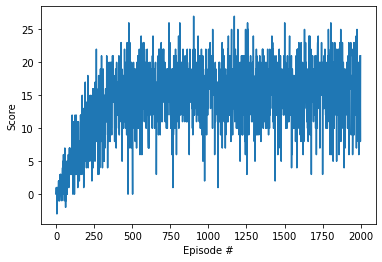

In [10]:
# plot the scores.
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

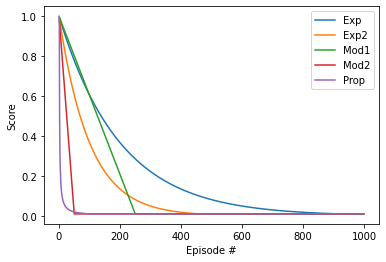

In [24]:
# plot some options for epsilon decay.

eps_start=1.0
eps_end=0.01
eps_decay=0.995


eps_1 = lambda i_episode: max(eps_end, eps_start*eps_decay**(i_episode))
eps_5 = lambda i_episode: max(eps_end, eps_start*eps_decay**(2*i_episode))
eps_2 = lambda i_episode: max(eps_end, eps_start-(eps_start-eps_end)/250*i_episode)
eps_4 = lambda i_episode: max(eps_end, eps_start-(eps_start-eps_end)/50*i_episode)
eps_3 = lambda i_episode: max(eps_end, eps_start/i_episode)

episodes = range(1, 1000)

r = []
eps = eps_start
for i_episode in episodes:
    r.append(eps)
    eps = max(eps_end, eps_decay**2*eps)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(episodes, [eps_1(i) for i in episodes], label='Exp')
plt.plot(episodes, [eps_5(i) for i in episodes], label='Exp2')
plt.plot(episodes, [eps_2(i) for i in episodes], label='Mod1')
plt.plot(episodes, [eps_4(i) for i in episodes], label='Mod2')
plt.plot(episodes, [eps_3(i) for i in episodes], label='Prop')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend()
plt.show()